Part 2 is here: https://www.kaggle.com/allohvk/the-nuts-and-bolts-of-sound-feature-engineering

I swear I would have paid more attention in my DSP - Digital Signal Processing classes had my good prof told me I could one day attempt to contribute in some tiny little way at studying and protecting the ecosystem. As it transpires, I unfortunately dont remember anything more than the full form of DSP. For those of you like me, I thought a small introduction to the theory of sound could be in order before attempting to take on the competition.

Sound is 'wave' that travels from the source to the human ear. It causes tiny hairs in our cochlea in our ear to vibrate and these vibrations are translated to electrical signals which are then relayed via the auditory nerve to the brain where they are finally interpreted. This is how we hear. 

So what exactly is this sound 'wave'. Let us say we pluck the string of a guitar. It causes the string to vibrate which in turn vibrates the air molecules around it. These knock into neighbouring particles and they start vibrating and this process repeats till the vibrations travel all the way to the ear. So effectively - Sound is all about vibrating molecules. These vibrations cause variations in pressure and in fact these variations in pressure is what is a wave. Something like the below:
<br><br><br>

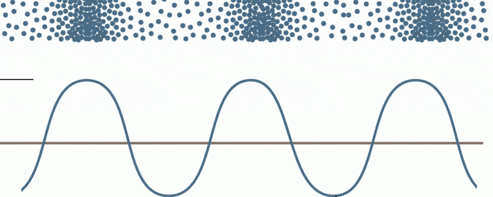

So Sound is not the 'Sound' we typically associate it with. Sound is just vibrations causing variations in pressure. The 'Sound' that we percieve is the interpretation of our brain. If a ear and brain is not there to percieve this sound, is it still a 'sound'? How about a tree falling when there is no one around. Is there a loud bang when it falls? Not related to this competition you may say..So let us move on.. but not before I give the opposite extreme. When we imagine or think of our favorite singer's song, we can 'hear' them singing in our brain. This time there is no air pressure or vibrations...we hear what we traditionally call the 'sound'. Our brain directly conjures up the sound out of literally thin air from its archives. So there must be a way to store sound in a different format and if could hit upon this format which has evolved over millinea, we would be billionaires but until then let us see how it is traditionally done.

Before we talk of digitizing as sound, let us talk about what are the different characteristics of a sound wave? Well it turns out, they are no different from any other wave..including the ones you see and enjoy on the beach. They have amplitude and a certain frequency and we can derive various other characteristics from these two. For e.g. Pitch is derived from the frequency. High frequency sounds are said to be "high pitched" & low frequency sounds are said to be "low pitched". But amplitude (strength) and frequency (1/length of the wave) are enough to describe a wave. So let us focus on this.

So how to we 'digitize' a wave'? Simple - by sampling them or taking multiple measurements over time. Let us say you ask me to record you singing for a duration of 1 second (any more and you feel I will run away as I couldnt bear it). If I could sample your voice 40000 times between the start and end (duration of 1 second), then I could get a pretty good representation of the sound you have made and store it digitally forever. Basically your sound can now be immortalised in a single Numpy array of size 40K. What are these 40K numbers? Well they represent the amplitude of the sound you were making at each point when I 'sampled' your voice. 

I could take 5000 samples instead of 40000 and still get a decent reproduction of the sound you have made. So a numpy array of 5000 or even 1000 is enough to (crudely) immortalise your sound for eternity, but for some strange reason, I may find no tangible benefit if I increase the sampling rate to 80K or 160K samples in 1 second. Can you guess why?

This is due to the fact that human ears can hear frequency between 20-20K Hz only...which means if there is a sound wave with frequency higher than that, then it does not register in our ears. In other words, if we take a very simple sinusoidal wave, our ears can hear the sound of this wave if the wave starts from 0, hits its peak, comes to 0 and goes down and then comes back to 0 - if all of this happens in 1/20 milli-seconds. Anything faster than that can be ignored. Since waves move up and down crossing zero, we have to sample a wave at a minimum 2 times (and probably much more). Which means if we take the fastest possible wave a human could hear and sample it twice, we should be able to recreate the sound very effectively. To sample the 20K wave twice would need a sampling rate of around 40K and this is a good sampling rate needed for a human ear.

Thus sound waves are digitised by sampling them at discrete intervals known as the 'sampling rate' and this sampling rate is typically 44.1kHz for CD's - which implies samples are taken 44,100 times per second.

Each sample value, as we discussed, is the amplitude of the wave at a particular time interval. But what is the range of this amplitude. Is it from 0 to 100 or -1000 to +1000? Well this depends on how detailed the sample should be and is known as the dynamic range of the signal. On CD's, they are stored on 2 bytes or 16 bit - thus storing ranges upto 65,536 amplitude values.

One last thing. Sound waves are almost always combination of multiple sound waves. So if we plot the 1 second immortal song of yours, it will look very different from the simple sinisoidal wave we saw above. We dont talk or sing in just one frequency. However the good news is that it is still a combination of multiple sound waves. If we could find a way to seperate your song into various components (basically split it into multiple waves), then we can still recreate your song by simply adding up all those individual waves. Each of those individual waves could have different amplitude and frequency. So another way of storing your song would be to split your song into multiple waves based on frequency. There is a perfect splitting machine for that and it is a simple mathematical function that you may have come across at some point of time in your college life. I swear that if my good Math professor had told me that one day I could use Fourier transform to analyze my favorite music, I would have paid better attention in class. 

We have covered quite a bit of theory already. 

Let us now look at the problem statement a bit before going to finish whatever little theory is left.

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import IPython.display as display
import seaborn as sns

In [ ]:
path = '/kaggle/input/rfcx-species-audio-detection/'
train_fp = pd.read_csv(path + 'train_fp.csv')
train_tp = pd.read_csv(path + 'train_tp.csv')
train_audio_files = os.listdir(path+'train')

In [ ]:
print('Length of True positives file:', len(train_tp))
print('Length of False positives file:', len(train_fp))
print('Num of training audio files:', len(train_audio_files))

In [ ]:
##Let us explore what is inside these files
train_tp.head()

In [ ]:
##Species and songtypes are easy to intuitively understand
train_tp['species_id'].value_counts()
##More or less evenly distriburted amongst 23 species

In [ ]:
train_tp['songtype_id'].value_counts()
##only 2 song types

In [ ]:
train_tp[['songtype_id','species_id']].groupby(['species_id', 'songtype_id']).agg('count')

Interesting to see that species 16 has only songtype 4 and 17,23 have both song types. All the remaining species have only one song type.

Let us move on to the other columns. The dataset is annotated...which means humans have analyzed it and have assigned labels to bird sounds. The start and end times of these annotations are given.

There is a fmin and fmax which stands for the lower and higher frequency of the annotated signal. Different species would have a different pitch and so this range of frequency (max-min) can be one fingerprint to identify a species.

You can observe the FP file similar to the above analysis. It contains the same species types and song types, has far greater records and are all false positives which means these sounds are not what is labelled/annotated against them.

Ok. Before we move on to the audio file, let us analyze the frequency range and duration per species

In [ ]:
train_tp['duration'] = train_tp.t_max-train_tp.t_min
train_tp['frange'] = train_tp.f_max-train_tp.f_min

In [ ]:
##plot the freq range for each species
sns.boxplot(data=train_tp,y='frange',x='species_id')
plt.gcf().set_size_inches(15, 10)

In [ ]:
##min frequency for each species
sns.boxplot(data=train_tp,y='f_min',x='species_id')
plt.gcf().set_size_inches(15, 10)

In [ ]:
##duration
sns.boxplot(data=train_tp,y='duration',x='species_id')
plt.gcf().set_size_inches(15, 10)

The frequency graph is more distinct than the time graph and will help categorize species better. This is the whole idea of something called spectogram. We will come to that later. Duration could also help identify particular species. Some like 17, 20, 23 seem to be characterized by higher duration of calls. We observed earlier that 17 and 23 are the only 2 species with multiple song types. 

Our graphs were fairly simple. You can visit: https://www.kaggle.com/gpreda/explore-the-rainforest-soundscape to get a very nice set of graphs. For e.g.

In [ ]:
def plot_feature_distribution(data_df, feature, feature2, title, kde_mode=False, hist_mode=True):
    f, ax = plt.subplots(1,1, figsize=(12,6))
    for item in list(data_df[feature2].unique()):
        d_df = data_df.loc[data_df[feature2]==item]
        try:
            sns.distplot(d_df[feature], kde=kde_mode, hist=hist_mode, label=item)
        except:
            pass
    plt.legend(labels=list(data_df[feature2].unique()), bbox_to_anchor=(1, 1), loc='upper right', ncol=2)
    plt.title(title)
    plt.show()
    
plot_feature_distribution(train_tp, 'f_min', 'species_id', "Minimum frequency distribution, TP data, grouped by species id")

In [ ]:
##compare this to the duration graph which has more overlapping
plot_feature_distribution(train_tp, 'duration', 'species_id', "Duration of song")

In [ ]:
##Let us move on to the audios.
data, sr = sf.read(path + 'train/' +'003bec244.flac')

We briefly discussed what 'data' is and what the sampling rate 'sr' is. We will come to what is data and sr, but first let us listen to this beautiful orcheastra of natural sounds

In [ ]:
display.Audio(path + 'train/' +'003bec244.flac')

Beautiful isnt it. Let us try to plot the above sound. We will also plot the annotated time ranges.

plotting is straightforward. The y-axis is the amplitude of the sound. So we just feed the value of the audio file which we just read to y-axis. I will explain what is the x-axis in a short while. For now, just think of the x-axis as a measure of time and let us just 'look' at this sound wave and the annotated part of it which is labelled as a species

In [ ]:
def plot_audio(data, sr, t_min, t_max):
    fig = plt.figure(figsize=(20,6))
    plt.plot(range(len(data)), data)
    plt.plot(range(int(t_min*sr), int(t_max*sr)), data[int(t_min*sr):int(t_max*sr)])
    plt.grid()
    
t_min = train_tp[train_tp.recording_id=='003bec244']['t_min']
t_max = train_tp[train_tp.recording_id=='003bec244']['t_max']
plot_audio(data, sr, t_min, t_max)

In [ ]:
print (t_min, '\n', t_max)

You can go back and play the sounds again. Somewhere around the 44th second, the species in question is annotated. The duration of the species calling is just about half a second. This is the part we are interested in and this is what we should label in the test dataset. There are also other sounds which could be mixed even during annotation. Could there be more than one annotation for a single audio file. Let us see

In [ ]:
train_tp['recording_id'].value_counts()

Yea, so we have multiple annotations made for a single recording. There also 'could' be overlapping times. If so we need to handle this carefully. 

In fact the problem statement here is to identify all bird species for each recording in a test dataset. Thankfully we dont have to automatically annotate them. We just have to say that - species a, d and f are in the recording 1, species x,y are in recording 2 etc. So this is a multilabel classification problem.

In [ ]:
print('sampling rate:', sr)
print(data.shape)
print(data)

So the sampling rate is 48000. This is high quality. In otherwords there are 48000 samples or readings taken every second. Multiplying this by the number of seconds (duration of audio) gives the total number of samples. Considering the audio file duration is 1 min, so the number of samples should be 60 * 48000 = 2880K which is what is returned by the soundwave library which has helped us convert from the raw audio to a nump array. In fact you can download the above audio file on your computer and check on its properties. The file type is .flac - free lossless audio codec. It is the version you would want to hear your favorite singers in. Not on MP3 or not even on Youtube even if it is HD. Lossless music takes a lot of space...but we are diverting here.

Anyway so we have the raw data which is 2880K length array. This is your x-axis in the wave representation above. The amplitude is on the y-axis - basically the numpy data. If we are sampling at 'n' times every second, then the annotated time starting t_min would be the (n multipled by t_min)th column in the numpy array and the end time would be (n multipled by t_max)th column. 

Now you might we wondering why we didnt use Librosa for loading the flac file? Let us try thta

In [ ]:
data, sr = librosa.load(path + 'train/' +'003bec244.flac')
print (sr, data.shape)

Did you notice what happened? By default the sampling rate in Librosa is approx 22KHz. So it loads that many samples (22K * 60) into the numpy array. This is not necesarily a bad thing. Many times we may want to voluntarily downsample because it may not distort the signal and we get twice the memory to play with. You can set sr to None to load the original sampling rate with - librosa.load(filename,sr=None)

In [ ]:
##let us plot the audio again
data, sr = sf.read(path + 'train/' +'003bec244.flac')
plot_audio(data, sr, t_min, t_max)

We may not need the rest of the sounds when we tag a particular annotated sound to a species. So we would need to crop the above data to just the orange part. What about the rest of the data? We need to think about that. For now let us try to clip

In [ ]:
##Let us crop for 5 seconds around the annotation
##This is just to get a feel. We will refine this funciton later
length = 5
center = np.round((t_min*sr + t_max*sr) / 2)
beginning = center - length / 2
print('T_min:', t_min.values, '\nT_max:', t_max.values, '\nannotated sound from:', (t_min*sr).values, '\nannotated sound to:', (t_max*sr).\
      values, '\ncenter:', center.values, '\ncut sound from:', beginning.values, '\ncut sound to:', (beginning+length*sr).values)
data = data[int(beginning):int(beginning+length*sr)].astype(np.float32)

In [ ]:
##let us plot the clipped audio
##We lost the annotation but thats ok for now
plot_audio(data, sr, t_min=0, t_max=5)

In [ ]:
from IPython.display import Audio
Audio(data, rate = 48000)

This gives a general idea of clipping. Later on while parsing the whole set of files we need to create a more generic function. We should introduce randomness as well for the beginning and end (of course around the annotation).

We saw how frequencies play a very important role in identifying sound. So a very good feature to feed to our model would be the frequency range over time. Note that we are not talking about the min and max frequency here. We want to take an audio signal - which is amplitude versus time - and convert this into a sort of a 3D representation which includes time, frequency and amplitude. If you remember the song recording you had immortalized some time back, we discussed that it is not just 1 single wave but a wave composed of many (diff freq) waves. We even discussed a splitter - the fourier transform which does that. But doing just that will not bring in the time angle. We will just get bunch of frequencies. We dont want that. We want all this info (frequency + amplitude) over the entire time duration of the entire audio. So the trick is to take Fourier transforms again and again over time and sort of club them together. The result is a spectogram.

We will need to create spectograms for all files. Let us create a function which does that. We will use the nice library Librosa which does all the heavy-duty work for us

In [ ]:
def plot_spectrogram(df, idx):
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(path+'train/'+df.recording_id[idx]+'.flac')
    xs = librosa.stft(x)
    xdb = librosa.amplitude_to_db(abs(xs))
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.gca().set_title(f"Spectrogram - file: {df.recording_id[idx]}")
    plt.colorbar()
    
plot_spectrogram(train_tp, 0)

This is a rich figure. We have converted the 2D wave (time versus amplitude) into frequency+amplitude over time. This is a derived feature and will help the model. Let us try to understand the pic a little bit. On the x-axis is the time. This is the easy part. Our audio file is 1 min long. What is the y-axis? This is the frequency. But what is the color? This is not directly the amplitude but we have converted it into decibels. This is because amplitude is a linear series and it does not help us much. Do you know why?

We don't hear loudness on a linear scale. So to double the perceived volume of a sound, we need to put 8 times as much energy into it (not 2 times). The distance between any 2 points x and y would not be equal to (x minus y) unlike in a linear scale. Logarithmic scales work much better when dealing with sounds. So, to express levels of sound meaningfully in numbers that are more manageable, a logarithmic scale is used, rather than a linear one. For a 3DB increase, sound energy is doubled, for 10DB - it is increased 10 times and for 20DB - it is increased by 100. A rock concert is 100 billion times as strong as the quietest sound you can hear.

Now, imagine the ear and brain perceived sound in a linear manner. If you could perceive the rock concert, then anything below that would be completely quiet. Your friend talking to you at maybe 5% to 10% of the volume of a rock concert, would sound like it is 1/billion times as loud and ideally should not be heard at all. But this is not what happens right? A logarithmic perception of things seems like a good way to spread things out reasonably and this is how nature designed hearing.

So the amplitude of the sound is converted into decibels which is a logarithmic scale. Thus in the function above, we take Short Term Fourier transforms - librosa.stft(x) - The Short-time Fourier transform, is a Fourier-related transform used to determine the sinusoidal frequency as it changes *over* time. This is converted to logarithmic scale - librosa.amplitude_to_db(abs(xs)). There are several parameters to be fine-tuned, but let us go ahead with the default ones for now as they work well.

Studying the spectogram above, there are mainly 5 diff frequencies at play. Most of it is repititive except the one around 5000Hz which dies off in 10 seconds. Keep in mind that a single species can produce multiple frequncies at same time (the sum of it is the final wave). Also our interest lies mainly around the 44th second which is annotated. Lastly let us plot the Mel spectogram

In [ ]:
def plot_mel_spectrogram(df, idx):
    plt.figure(figsize=(12,6))
    x , sr = librosa.load(path+'train/'+df.recording_id[idx]+'.flac')
    xs = librosa.feature.melspectrogram(x)
    xdb = librosa.amplitude_to_db(abs(xs))
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.gca().set_title(f"Mel spectrogram - file: {df.recording_id[idx]}")
    plt.colorbar()
    
plot_mel_spectrogram(train_tp, 0)

Aah. The 5 bands we talked about are more clearly segregated here. But the frequency scale looks messed up. Could Librosa have gotten it wrong? Let us see..

A Mel Spectrogram is a Spectrogram with the Mel Scale on its y axis. Now what is a Mel scale? No it is not something named after the favorite scale of Mel B the british singer. Mel stands for Melody and Mel scale is something that we do to frequency that we just did to amplitude a while back. 

Just like amplitude, the human ear also does not percieve frequencies on a linear scale. The difference between 100 and 500Hz is not the same as the difference between 5000 and 5400 Hz. So a Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also “sound” to humans as they are equal in distance from one another. It partitions the Hz scale into bins, and transforms each bin into a corresponding bin in the Mel Scale, using overlapping triangular filters. Discrete Cosine Transform (DCT) is applied after that to “squeeze” the results(called coefficients), increasing the importance of the first coefficients and reducing the importance of the last ones. Unfortunately, I didnt even remember the full form of DCT. Thankfully the libraries pretty much give what we want in 1 line of code. 

The hosts have also given the competition data in the TFRecord format. It does not look as if there is any new information here to analyze. A tfrecord dataset is of immense help during training because then we do not need to load the complete dataset into memory. We can ingest data piece by piece with the dataset class. Tensorflow takes care of loading more data while GPU is crunching numbers. It is also very fast since we do not need to load data into a numpy array first and then ingest it back into keras. We just stay C++ end to end.

So to sum it up, a Mel spectogram hopefully carries better information than a simple spectogram which hopefully carries better information than a raw audio signal. So what next?

We have to use augmentations. This expands the training dataset. We can augment the Mel spectograms or we can augment the raw signal itself. Augmentation for spectrogram is something similar to image augmentation. There are minor differences though when comparing with image augmentations. Applying augmentations that ignores this (time, freq axis) like  flip, rotation, etc...will serve no purpose. It makes more sense to augment the waveform itself and then create respective spectograms. We could add noise, shift and stretch time, increase decrease volume etc.

In his wonderful notebook: https://www.kaggle.com/hidehisaarai1213/rfcx-audio-data-augmentation-japanese-english, @hidehisaarai1213 san has introduced a few possible Augmentation methods for raw waveform:

- AddGaussianNoise
- GaussianNoiseSNR
- PinkNoiseSNR
- PitchShift
- TimeStretch
- TimeShift
- VolumeControl

His is a gem of a notebook and I doubt if you will find this kind of information anywhere else on the net in one place. It is so nicely explained that there is no point in replicating anything in my notebook.

This is another good source for augmentation: https://www.kaggle.com/gopidurgaprasad/audio-augmentation-albumentations

Did we miss anything? Well there are a host of other derived features besides Mel spectograms. They could be extensions to the spectograms we discussed (images) or they could be features related to the original data (numerical). See for eg this notebook: https://www.kaggle.com/mrutyunjaybiswal/rainforest-tfrecords-with-audio-eda-metrics

What next after augmentations?

Many swear by CNN's from here-on. They convert all their sounds to images like the above and then the CNN models are supposed to take over from here on and do the learning, labelling etc. Others believe that all this is not the right approach. Sound is a time signal. Who better to deal with time-based signals other than RNNs, LSTMs and the big bully of all - the formidable transformers? Yet others, combine the two and we have recurring CNNs 

And so we must take a break here while we study which direction to move ahead in...

More to come...